<a id=contents></a>

# Exploratory Data Analysis
## Our clean data at a glance


[1. Explore POS and NE Tags](#insp)

[2. Target feature distribution](#corr)

[3. Measuring the correlation between variables](#bar)

[4. Creating text-based features](#one)

[5. Exploring text-based features](#three)

[6. Conclusions and feature selection for modelling](#conc)

In [139]:

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from sklearn.linear_model import LogisticRegression
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import string

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re
tokenizer = RegexpTokenizer(r'\b\w{3,}\b')
stop_words = list(set(stopwords.words("english")))
stop_words += list(string.punctuation)

import warnings
warnings.filterwarnings('ignore')

from collections import Counter
import scipy.stats as ss
from dython.nominal import conditional_entropy, associations


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df = pd.read_csv('clean_data/clean_data.csv', ).drop(columns=['Unnamed: 0'])
df.head()

,Sentence #,Word,POS,Tag
0,1.0,Thousands,NNS,O
1,1.0,of,IN,O
2,1.0,demonstrators,NNS,O
3,1.0,have,VBP,O
4,1.0,marched,VBN,O


<a id=insp ><a/> 

## 1. Explore POS and NE Tags
    
[LINK to table of contents](#contents)

In [6]:
pos_tag_breakdown = df.groupby(by=['POS', 'Tag']).count().sort_values(by='Word', ascending=False)
pos_tag_breakdown

,,Sentence #,Word
POS,Tag,,
NN,O,9171,9171
IN,O,7622,7622
DT,O,6275,6275
.,O,5190,5190
NNS,O,4681,4681
...,...,...,...
DT,I-art,1,1
RBR,B-tim,1,1
JJ,I-eve,1,1


In [7]:
pos_tag_breakdown.Word.quantile(.75)

154.25

In [8]:
# Since there are so many POS and NE categories, we'll only take the combinations that have a frequency above 
# the 75th quantile of 154
pos_tag_trim = pos_tag_breakdown.loc[pos_tag_breakdown.Word>154]
pos_tag_trim.head()

,,Sentence #,Word
POS,Tag,,
NN,O,9171,9171
IN,O,7622,7622
DT,O,6275,6275
.,O,5190,5190
NNS,O,4681,4681


In [9]:
pos_tag_trim = pos_tag_trim.reset_index()

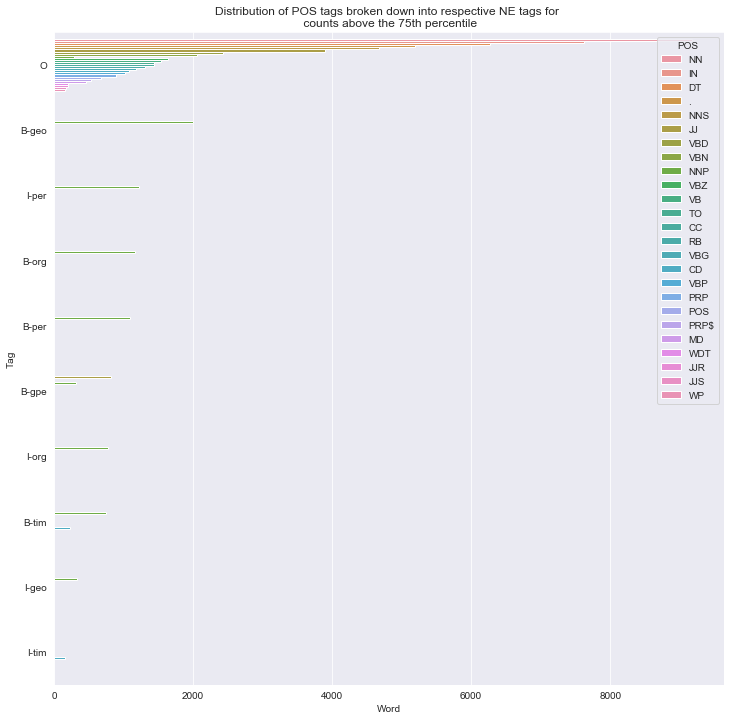

In [10]:
plt.figure(figsize=(12,12))
plt.title('Distribution of POS tags broken down into respective NE tags for \n counts above the 75th percentile')
sns.barplot(y = pos_tag_trim['Tag'], x= pos_tag_trim['Word'], hue = pos_tag_trim['POS']);

So we can see that, for the most numerically significant groups, the distribution is dominated by 'Other' (i.e. non-Named Entities). The largest group of named entities is the ~2000-odd geographical entities (B-geo). If you're struggling to understand the BIO formatting, know that the B signifies the beginning of an NE sequence (so 'B-geo' would be the *first* word of sequences like 'Europe' and 'South America') whereas I only relates to the words after the first one in an NE sequence (so 'Europe' would not be categorised as 'I-geo', but the second word of 'South America' would). The massive gap between the frequency of B-geo, NNP (2000) and I-geo, NNP (<300) tells us that generally speaking most proper noun geographical entities consist of a single token (like 'Europe', 'Asia', 'Nile').

Now let's visualise what this would look like without any of the non-entities. 

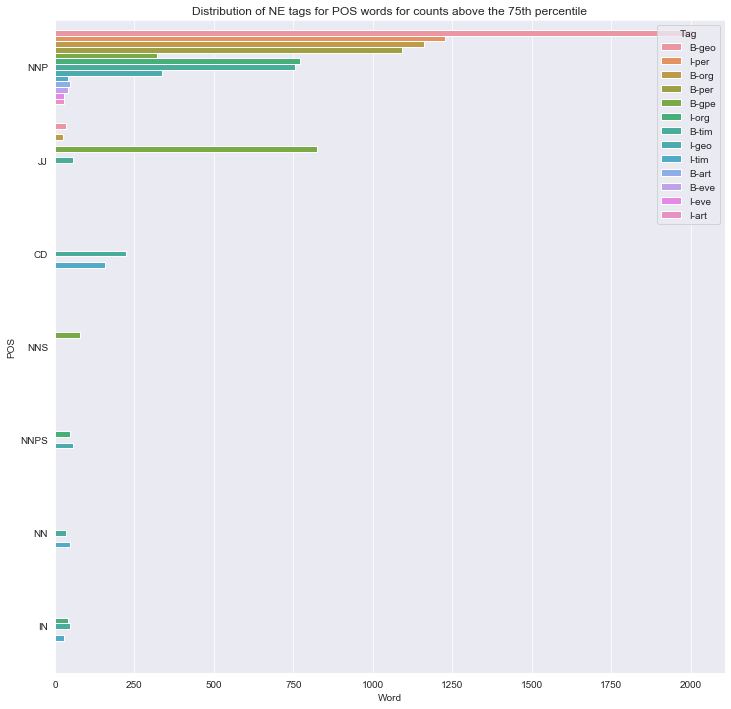

In [11]:
NE_breakdown = df.loc[df.Tag!='O'].groupby(by=['POS', 'Tag']).count().sort_values(by='Word', ascending=False)

NE_breakdown_trim = NE_breakdown.loc[NE_breakdown.Word>NE_breakdown.Word.quantile(.75)].reset_index()

plt.figure(figsize=(12,12))
plt.title('Distribution of NE tags for POS words for counts above the 75th percentile')
sns.barplot(y = NE_breakdown_trim['POS'], x= NE_breakdown_trim.Word, hue=NE_breakdown_trim['Tag'],);

Looking at our indexes, we can see that the vast majority of our NEs are indeed proper nouns (NNP), spanning multiple POS categories. 

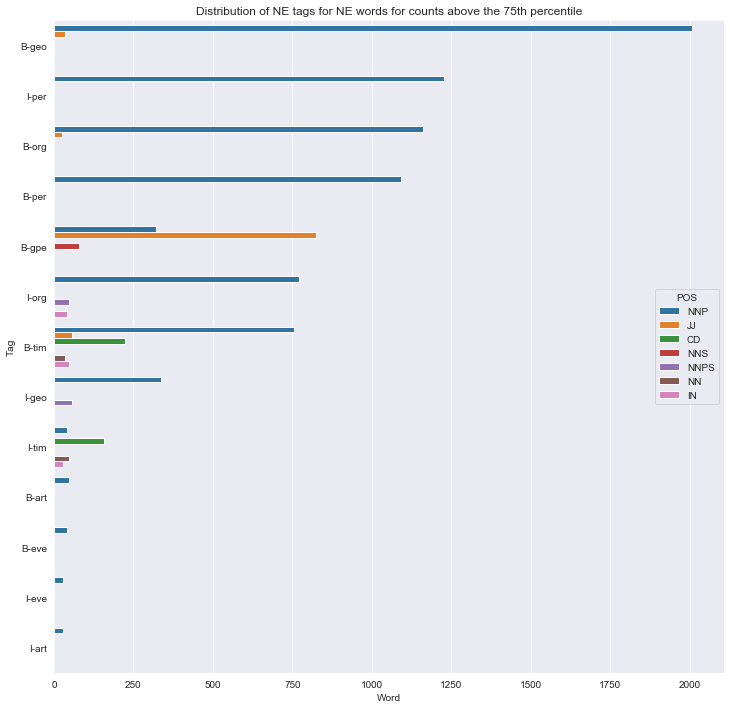

In [12]:
plt.figure(figsize=(12,12))
plt.title('Distribution of NE tags for NE words for counts above the 75th percentile')
sns.barplot(y = NE_breakdown_trim['Tag'], x= NE_breakdown_trim.Word, hue=NE_breakdown_trim['POS'],);

The same trends is reflected when plotting NE Tags broken down via POS. The only significant NE category to buck the trend is B-GPE. Let's inspect a few examples and see why. 

In [13]:
df.loc[(df.Tag=='B-gpe') & (df.POS=='JJ')].head(10)

,Sentence #,Word,POS,Tag
18,1.0,British,JJ,B-gpe
102,5.0,English,JJ,B-gpe
126,6.0,British,JJ,B-gpe
196,10.0,Iranian,JJ,B-gpe
276,13.0,European,JJ,B-gpe
293,13.0,Iranian,JJ,B-gpe
300,14.0,Nigerian,JJ,B-gpe
326,15.0,German,JJ,B-gpe
363,16.0,German,JJ,B-gpe
515,22.0,Somali,JJ,B-gpe


As you'd expect this comes from the wide variety of adjectives (JJ) that identify a particular geo-political entity, e.g. "the German Army", "the Iranian Embassy". 

<a id=corr ><a/> 

## 2.  Target feature distribution
    
[LINK to table of contents](#contents)

As we can see, almost 90% of the NE tags are 'O' - not Named Entities. 

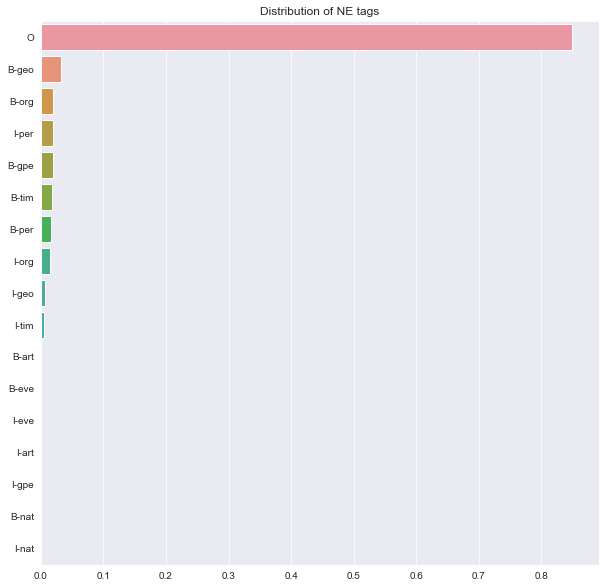

In [14]:
plt.figure(figsize=(10,10))
plt.title('Distribution of NE tags')
sns.barplot(x = df.Tag.value_counts(True).values, y= df.Tag.value_counts(True).index,);

Removing the 'O's, we see that geographical entities (e.g. the Nile) dominate, followed by organisations (UNICEF), geo-political (NATO) and personal entities (Tony Blair). We're dealing with a severe class imbalance, for which the only reasonable solution will be to provide our models with class weights. 

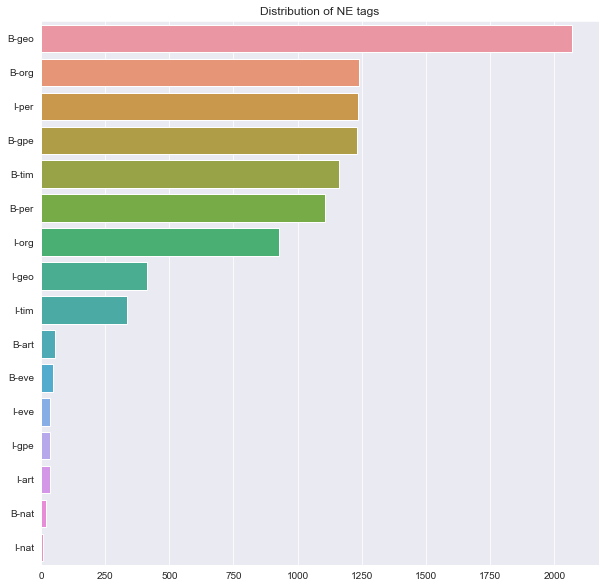

In [15]:
plt.figure(figsize=(10,10))
plt.title('Distribution of NE tags')
sns.barplot(x = df.loc[df.Tag!='O'].Tag.value_counts().values, y= df.loc[df.Tag!='O'].Tag.value_counts().index,);

<a id=bar ><a/> 

## 3. Measuring the correlation between variables
   
[LINK to table of contents](#contents)

For our categorical variables (POS and NE tags), we'll be plotting a confusion matrix of the Uncertainty Coefficient (or Theil's U), which can be thought of as *normalised mutual information*. I'll go into the maths in more detail further down with an example. 

I'll be using the dython package very kindle provided [here](https://github.com/shakedzy/dython). 

In [138]:

def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

Now we don't necessarily want to look at all of the categories in POS and Tag, since that would be useless for the most part. Previously we identified what the most frequent POS tags were for NE words and we can take the top ones here. 

In [41]:
NE_breakdown_trim.POS.value_counts(ascending=False).index

Index(['NNP', 'JJ', 'IN', 'NNPS', 'NN', 'CD', 'NNS'], dtype='object')

In [48]:
corr_df = df.loc[df.Tag.isin(['B-gpe', 'B-org', 'I-per', 'B-per', 'I-org', 'B-tim', 'I-gpe', 'I-tim'])]
corr_df = corr_df.loc[corr_df.POS.isin(['NNP', 'JJ', 'IN', 'NNPS', 'NN', 'CD', 'NNS'])]

corr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7132 entries, 18 to 66158
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sentence #  7132 non-null   float64
 1   Word        7132 non-null   object 
 2   POS         7132 non-null   object 
 3   Tag         7132 non-null   object 
dtypes: float64(1), object(3)
memory usage: 278.6+ KB


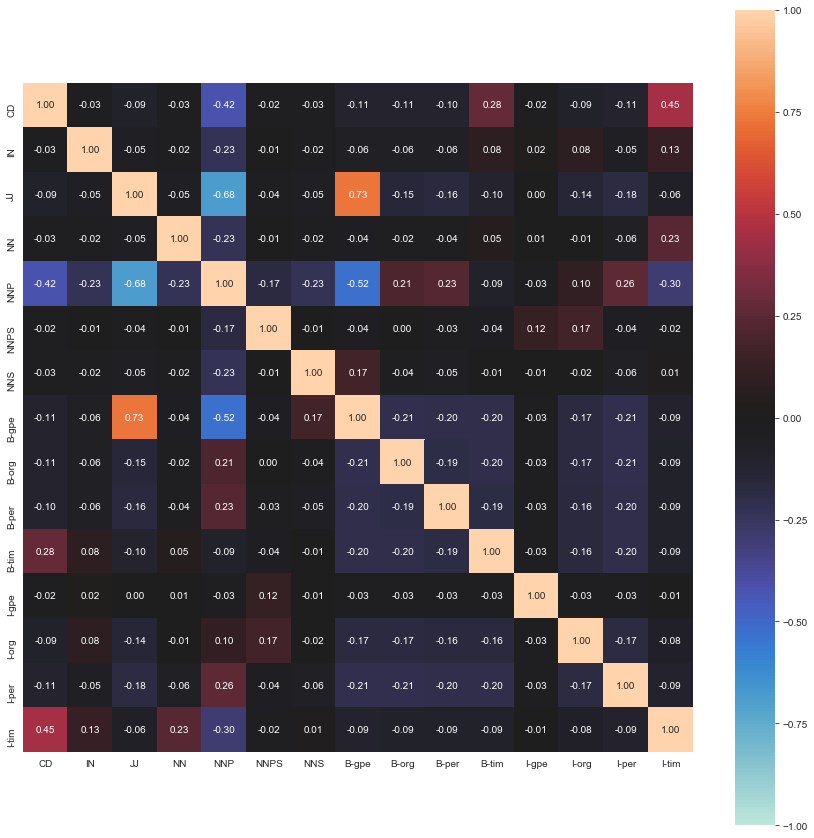

In [50]:
associations(pd.concat([pd.get_dummies(corr_df.POS), pd.get_dummies(corr_df.Tag)], axis=1), theil_u=True, figsize=(15,15));

Now what we see above very neatly visualises and confirms some of our prior insights:
* the strongest positive relationship is between adjectives (JJ) and geo-political entities (B-gpe)
* conversely, there's a strong negative relationship (-0.52) between proper singular nouns (NNP) and geo-political entities (B-gpe)

Although this might seem like a fuzzy picture of the relationships in our data, the variation in uncertainty coefficients across this map indicate to me that POS tags are a valuable feature to include in any model, and we will be using them throughout most if not all future models. 

<a id=one ><a/> 

## 4. Creating text-based features
    
[LINK to table of contents](#contents)

What we've looked at so far has been the target variable and the POS feature. In our feature-based model, we will be creating new features from the text itself, based partially on previous work done in academic papers but also on intuition and understanding of language. Before we can select these features so easily, we will first draft a list, create the features, create a binary column for whether a word is an NE or not (which will make the correlations easier to plot) and then we'll select which ones to include in our model. 

### Proposed features table:

| Feature                          | Python(pseudo)code for obtaining it        |   Motivation |
|:--------------------             |:------------------------------------       |:-------------|
|Is word titled-like?              | df.text[i].istitle()                       |Title-like words like "Ministry of Defense" more likely to be NEs |
|Length of word                    | len(df.text[i])                            |Very short words (<4 letters) less like to be NEs); very long words have higher likelihood | 
|Is word CAPITALISED?              | df.text[i].isupper()                       |Capitalised words, like acronyms, are very likely to be NEs (e.g. UNICEF) |
|Is the word numerical?            | df.text[i].isdigit()                       |Numbers are likely to be associated with date and time NEs |
|Is previous word an NE?           | df.Tag[i-1]!='O'                           |If the prior word is an NE, given the high number of "I-" Tags, there will be a more significant chance of the word under consideration being also NE |
|What's the previous word's POS    | df.POS[i-1]                                |Important to not just take into account the current POS tag, but the previous one, since these kind of syntactical relationships will correspond to the type of NE we have | 
|What's the POS two words ago?     | df.POS[i-2]                                |Similar to above | 
|Is it the first in sentence?      | df.Sentence[i]==df.Sentence[i-1]           |A lot of articles will start with introducing an NE, especially if that's the focus of a news story and you introduce it into the reader's limelight directly |
|How many times does the word occurr in the sentence |  xxxxx                   | Words with a higher occurrence will likely be the subject of a text | 



------------


# WIP
### Proposed Feature Interactions :
| Feature interaction              | Python(pseudo)code for obtaining it        |   Motivation |
|:--------------------             |:------------------------------------       |:-------------| 
|Previous word NE & previous POS   | df.Tag[i-1]!='O' * df.POS[i-1]             |If the prior word is an NE, given the high number of "I-" Tags, there will be a more significant chance of the word under consideration being also NE |





### Creating features

In [4]:
test = df.iloc[:10]
test

,Sentence #,Word,POS,Tag
0,1.0,Thousands,NNS,O
1,1.0,of,IN,O
2,1.0,demonstrators,NNS,O
3,1.0,have,VBP,O
4,1.0,marched,VBN,O
5,1.0,through,IN,O
6,1.0,London,NNP,B-geo
7,1.0,to,TO,O
8,1.0,protest,VB,O
9,1.0,the,DT,O


In [50]:
unique, counts = np.unique(test.values[:,1], return_counts=True)
print(unique, counts)

['London' 'Thousands' 'demonstrators' 'have' 'marched' 'of' 'protest'
 'the' 'through' 'to'] [1 1 1 1 1 1 1 1 1 1]


In [47]:
import collections as C
counter()

In [67]:
n = np.zeros((2,2), dtype='O')
n[0,0] = 'a'
n

array([['a', 0],
       [0, 0]], dtype=object)

In [154]:
%time

def binarise_tags(df, col : str, negative_class_val='O'):
    """Takes in dataframe, multiclass target column and the value assoc with the negative class and adds a column 
    where the target col is binary. 
    Params:
    df - pandas dataframe
    col - (str) target column
    negative_class_val - (int/str/float) what is the value of the negative class; default : 'O'
    ------------------------
    Returns Pandas Dataframe"""
    df['binary_target'] = 0
    df.loc[df[col] !=negative_class_val, 'binary_target'] = 1
    return df

def add_new_feat(df, output_col_names : list, return_as_df = True):
    """Takes in dataframe, name of target column (e.g. 'Text'), and the name of the new column to be created.
    Assumes the order of columsn is as follows:
    0 - sentence int
    1 - text
    2 - POS tag
    3 - NE tag
    4 - binarised NE tag
    Params:
    df - pandas dataframe
    output_col_names - (str) name of the new columns of the final dataframe
    return_as_df - (bool) whethe the output should be a pandas dataframe (default True) or, for the purposes
    of computational speed, simply be a numpy array
    ---------------
    Returns pandas dataframe OR numpy array"""
    
    data = df.copy().values
    
    assert ((return_as_df) & (output_col_names!=None)), "Column names error: if you want a dataframe you must supply a list of column names"
    
    row_i = 0
    col_i = 0
    new_feat = np.zeros((data.shape[0],(len(output_col_names)- len(df.columns))), dtype='O')
    for row_i in range(len(data)):
        new_feat[row_i, 0] = int(data[row_i, 1].istitle()) #is It Capitalised Like A Title?
        new_feat[row_i, 1] = len(data[row_i, 1]) # how long is the word?
        new_feat[row_i, 2] = int(data[row_i, 1].isupper()) #IS IT ALL IN UPPERCASE?
        new_feat[row_i, 3] = int(data[row_i, 1].isdigit()) #it is numerical? e.g. 02-01-2002
        if row_i==0:
            new_feat[row_i, 4] = 0 # what's previous NE?
            new_feat[row_i, 5] = '' # what's the previous POS tag?
            new_feat[row_i, 6] = '' # what's the POS tag 2 words ago?
            new_feat[row_i, 7] = 1 # is the first in the sentence?
            new_feat[row_i, 8] = 0
        else:
            new_feat[row_i, 4] = int(data[row_i-1, 3]!='O') # is previous an NE?
            new_feat[row_i, 5] = data[row_i-1, 2] # what's the previous POS tag?
            try:
                new_feat[row_i, 6] = data[row_i-2,2] # what's the POS tag 2 words ago?
            except:
                new_feat[row_i, 6] = ''
            new_feat[row_i, 7] = int(data[row_i, 0] != data[row_i - 1, 0]) # is the first in the sentence?
            new_feat[row_i, 8] = int(data[row_i-1, 2]==data[row_i, 2]) #is this word's pos tag the same as the previous one?
            
    assert len(new_feat)==len(data), "Mismatch in shape between new features length of {} and input data of len {}".format(len(new_feat),len(data))

    new_data = np.concatenate([data, new_feat], axis=1)
    
    if return_as_df:
        new_data = pd.DataFrame(new_data, columns = output_col_names)
        for col in new_data.columns:
            if type(new_data[col][0])!=str:
                new_data[col] = new_data[col].astype('int64')
    
    return new_data

test_bin = binarise_tags(test, 'Tag')
test_new = add_new_feat(test_bin, ['Sentence #', 'Word', 'POS', 'Tag', 'binary_target', #original column names
                                     'is_title', 'length', 'is_upper','is_digit',
                                     'is_prev_NE','prev_-1_POS','prev_-2_POS', 'is_first_in_sentence', 
                                  'is_prev_pos_same_as_current'])
test_new.head()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


,Sentence #,Word,POS,Tag,binary_target,is_title,length,is_upper,is_digit,is_prev_NE,prev_-1_POS,prev_-2_POS,is_first_in_sentence,is_prev_pos_same_as_current
0,1,Thousands,NNS,O,0,1,9,0,0,0,,,1,0
1,1,of,IN,O,0,0,2,0,0,0,NNS,DT,0,0
2,1,demonstrators,NNS,O,0,0,13,0,0,0,IN,NNS,0,0
3,1,have,VBP,O,0,0,4,0,0,0,NNS,IN,0,0
4,1,marched,VBN,O,0,0,7,0,0,0,VBP,NNS,0,0


In [155]:
%time
df_bin = binarise_tags(df, 'Tag')
feature_df = add_new_feat(df_bin, ['Sentence #', 'Word', 'POS', 'Tag', 'binary_target', #original column names
                                     'is_title', 'length', 'is_upper','is_digit',
                                     'is_prev_NE','prev_-1_POS','prev_-2_POS', 'is_first_in_sentence',
                                  'is_prev_pos_same_as_current'])

feature_df.head(40)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs


,Sentence #,Word,POS,Tag,binary_target,is_title,length,is_upper,is_digit,is_prev_NE,prev_-1_POS,prev_-2_POS,is_first_in_sentence,is_prev_pos_same_as_current
0,1,Thousands,NNS,O,0,1,9,0,0,0,,,1,0
1,1,of,IN,O,0,0,2,0,0,0,NNS,.,0,0
2,1,demonstrators,NNS,O,0,0,13,0,0,0,IN,NNS,0,0
3,1,have,VBP,O,0,0,4,0,0,0,NNS,IN,0,0
4,1,marched,VBN,O,0,0,7,0,0,0,VBP,NNS,0,0
5,1,through,IN,O,0,0,7,0,0,0,VBN,VBP,0,0
6,1,London,NNP,B-geo,1,1,6,0,0,0,IN,VBN,0,0
7,1,to,TO,O,0,0,2,0,0,1,NNP,IN,0,0
8,1,protest,VB,O,0,0,7,0,0,0,TO,NNP,0,0
9,1,the,DT,O,0,0,3,0,0,0,VB,TO,0,0


In [156]:
feature_df.shape

(66161, 14)

<a id=three ><a/> 

## 5. Exploring text-based features
    
[LINK to table of contents](#contents)

First let's explore the correlations amongst all the purely numerical / already encoded variables. We're putting the POS variables to one side for now:

In [157]:
num_feat_df = feature_df.iloc[:, 4:].drop(columns=['prev_-1_POS', 'prev_-2_POS'])
num_feat_df.head()

,binary_target,is_title,length,is_upper,is_digit,is_prev_NE,is_first_in_sentence,is_prev_pos_same_as_current
0,0,1,9,0,0,0,1,0
1,0,0,2,0,0,0,0,0
2,0,0,13,0,0,0,0,0
3,0,0,4,0,0,0,0,0
4,0,0,7,0,0,0,0,0


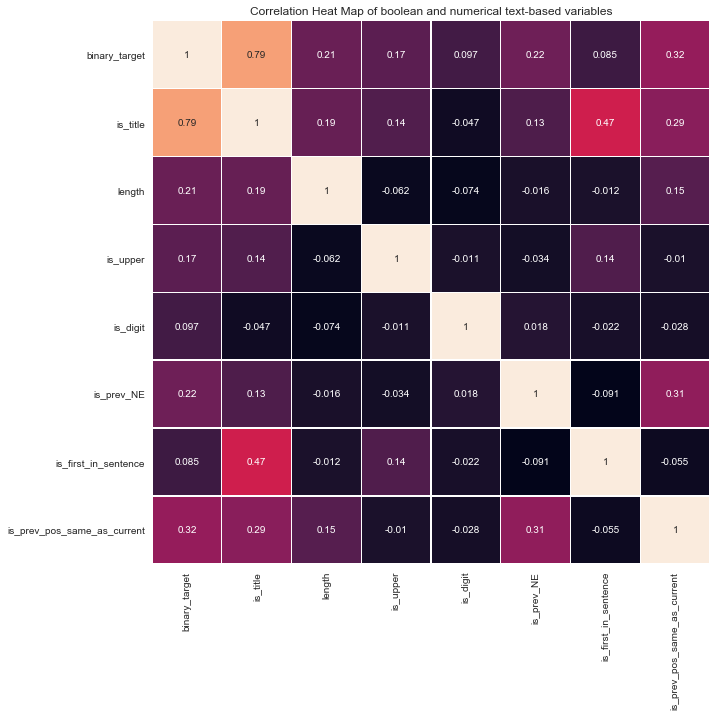

In [158]:
plt.figure(figsize=(10,10))
plt.title('Correlation Heat Map of boolean and numerical text-based variables')
sns.heatmap(num_feat_df.corr('pearson'), annot=True, cbar=False, linewidths=0.2);

So, from this we can see that the strongest predictors amongst the numerical variables are :
* whether the word is title-like (0.79)
* some significant correlation between NEs and the condition of whether the previous word's POS matched the current one's (0.32)
* there's a faint correlation between NEs and the length of the word (0.21)
* there's a surprisingly faint correlation as well with whether the previous word was an NE (0.22)
* an event fainter correlation for is_digit and is_upper

Now let's look at the Uncertainty coefficient matrices for:
- the current word's POS
- the POS tag of the previous word and 
- the POS tag two words before

In [163]:
dummies_df = feature_df[['binary_target','POS',]]
dummies_df = pd.get_dummies(dummies_df, columns = ['POS',])
dummies_df.head()

,binary_target,POS_$,POS_.,POS_:,POS_CC,POS_CD,POS_DT,POS_EX,POS_IN,POS_JJ,...,POS_VB,POS_VBD,POS_VBG,POS_VBN,POS_VBP,POS_VBZ,POS_WDT,POS_WP,POS_WP$,POS_WRB
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


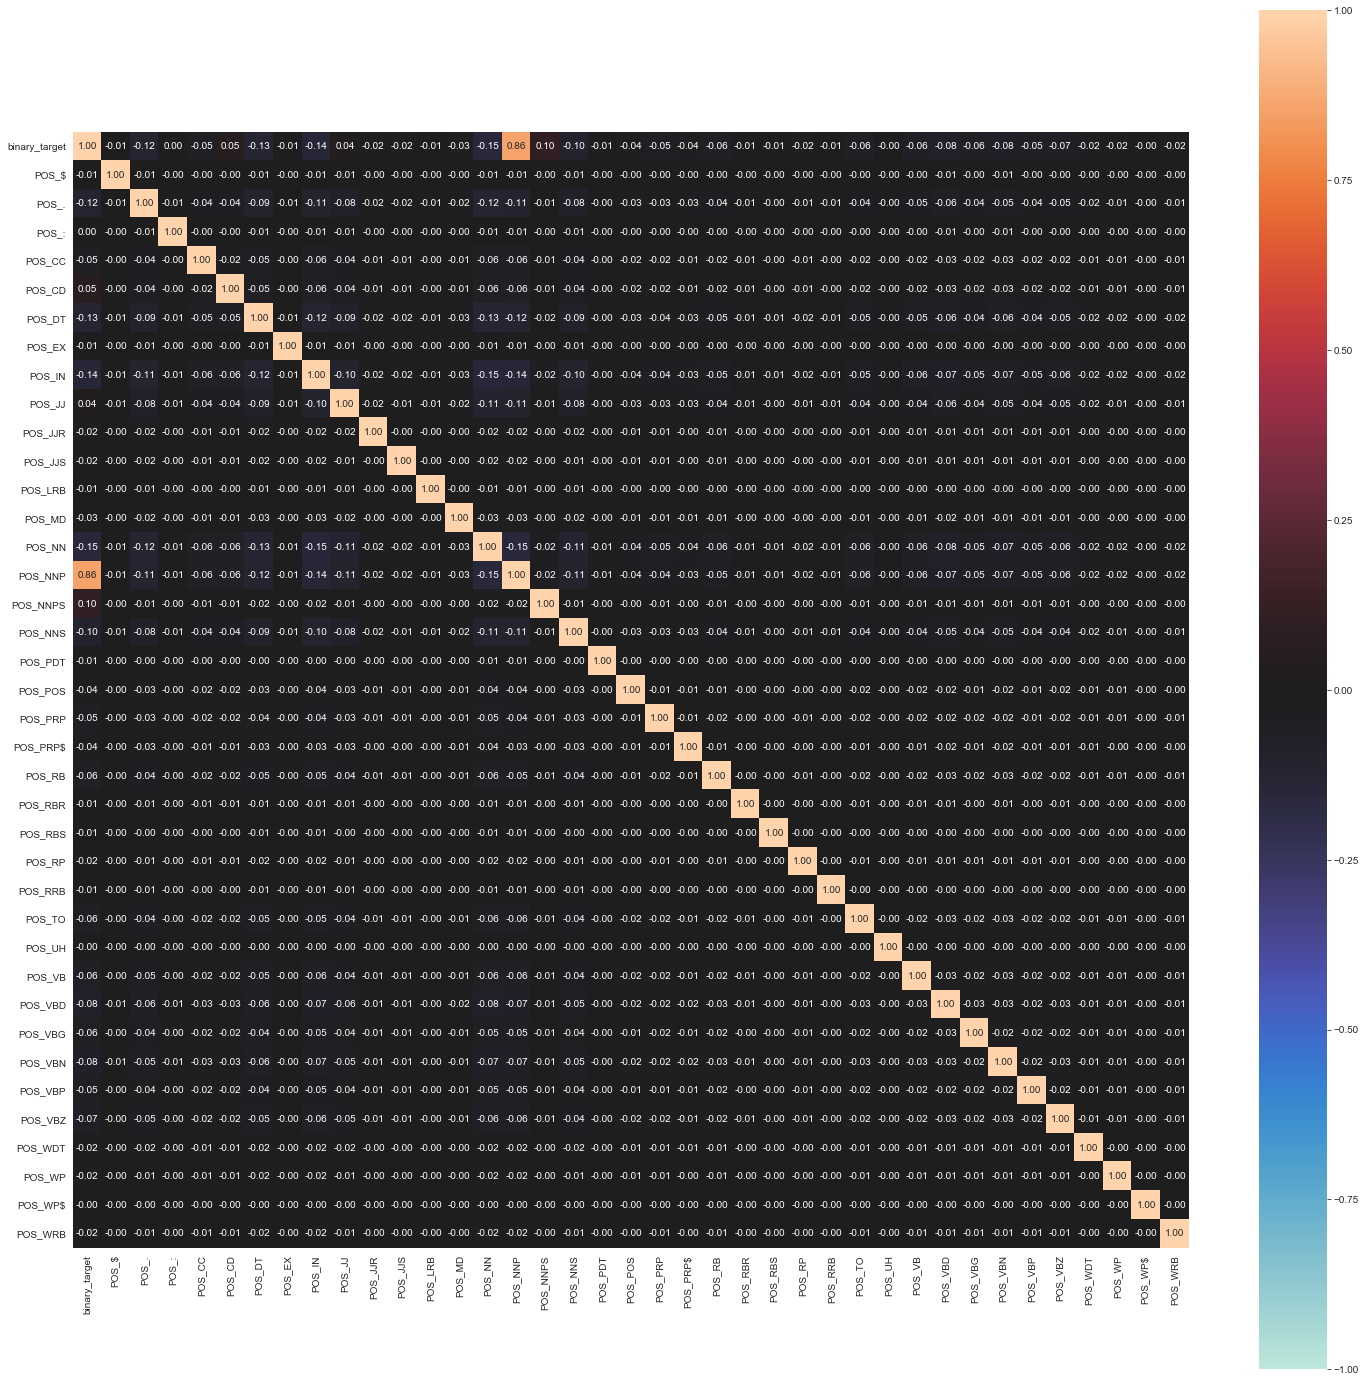

In [164]:
associations(dummies_df, theil_u=True, figsize=(25,25));

Given the coefficients here, we'll be primarily interested in:
* POS_NNP
* POS_NN
* POS_IN
* POS_DT
* POS_.

In [159]:
dummies_df_1 = feature_df[['binary_target','prev_-1_POS',]]
dummies_df_1 = pd.get_dummies(dummies_df_1, columns = ['prev_-1_POS',])
dummies_df_1.head()

,binary_target,prev_-1_POS_,prev_-1_POS_$,prev_-1_POS_.,prev_-1_POS_:,prev_-1_POS_CC,prev_-1_POS_CD,prev_-1_POS_DT,prev_-1_POS_EX,prev_-1_POS_IN,...,prev_-1_POS_VB,prev_-1_POS_VBD,prev_-1_POS_VBG,prev_-1_POS_VBN,prev_-1_POS_VBP,prev_-1_POS_VBZ,prev_-1_POS_WDT,prev_-1_POS_WP,prev_-1_POS_WP$,prev_-1_POS_WRB
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


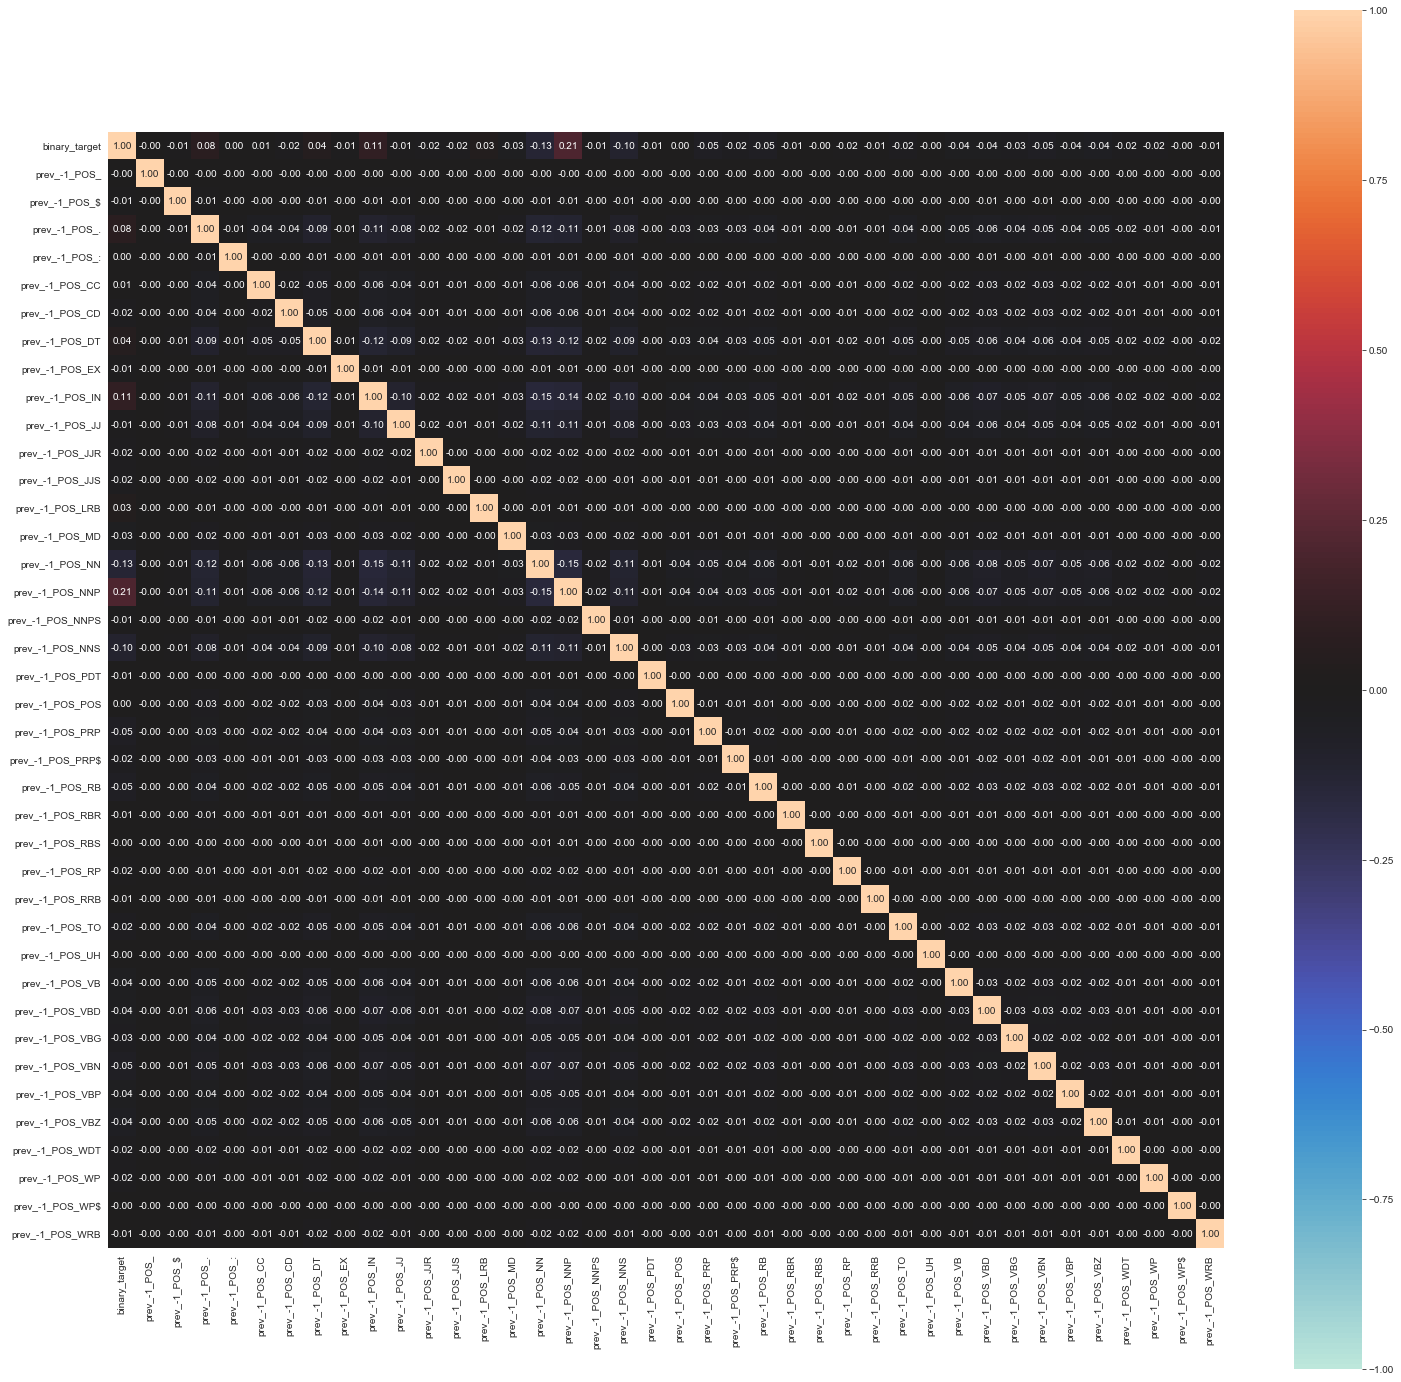

In [160]:
associations(dummies_df_1, theil_u=True, figsize=(25,25));

For the previous word's POS tags, there's only one uncertaintly coefficient of any notice, namely when the previous word is a singular proper noun (NNP) - 0.21. 
This is followed at 0.13 by the prev_-1_POS of NN (singular common noun). We will take these 2 variables forward. Now let's see what the picture looks like for the word two steps before:

In [161]:
dummies_df_2 = feature_df[['binary_target','prev_-2_POS',]]
dummies_df_2 = pd.get_dummies(dummies_df_2, columns = ['prev_-2_POS',])
dummies_df_2.head()

,binary_target,prev_-2_POS_,prev_-2_POS_$,prev_-2_POS_.,prev_-2_POS_:,prev_-2_POS_CC,prev_-2_POS_CD,prev_-2_POS_DT,prev_-2_POS_EX,prev_-2_POS_IN,...,prev_-2_POS_VB,prev_-2_POS_VBD,prev_-2_POS_VBG,prev_-2_POS_VBN,prev_-2_POS_VBP,prev_-2_POS_VBZ,prev_-2_POS_WDT,prev_-2_POS_WP,prev_-2_POS_WP$,prev_-2_POS_WRB
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


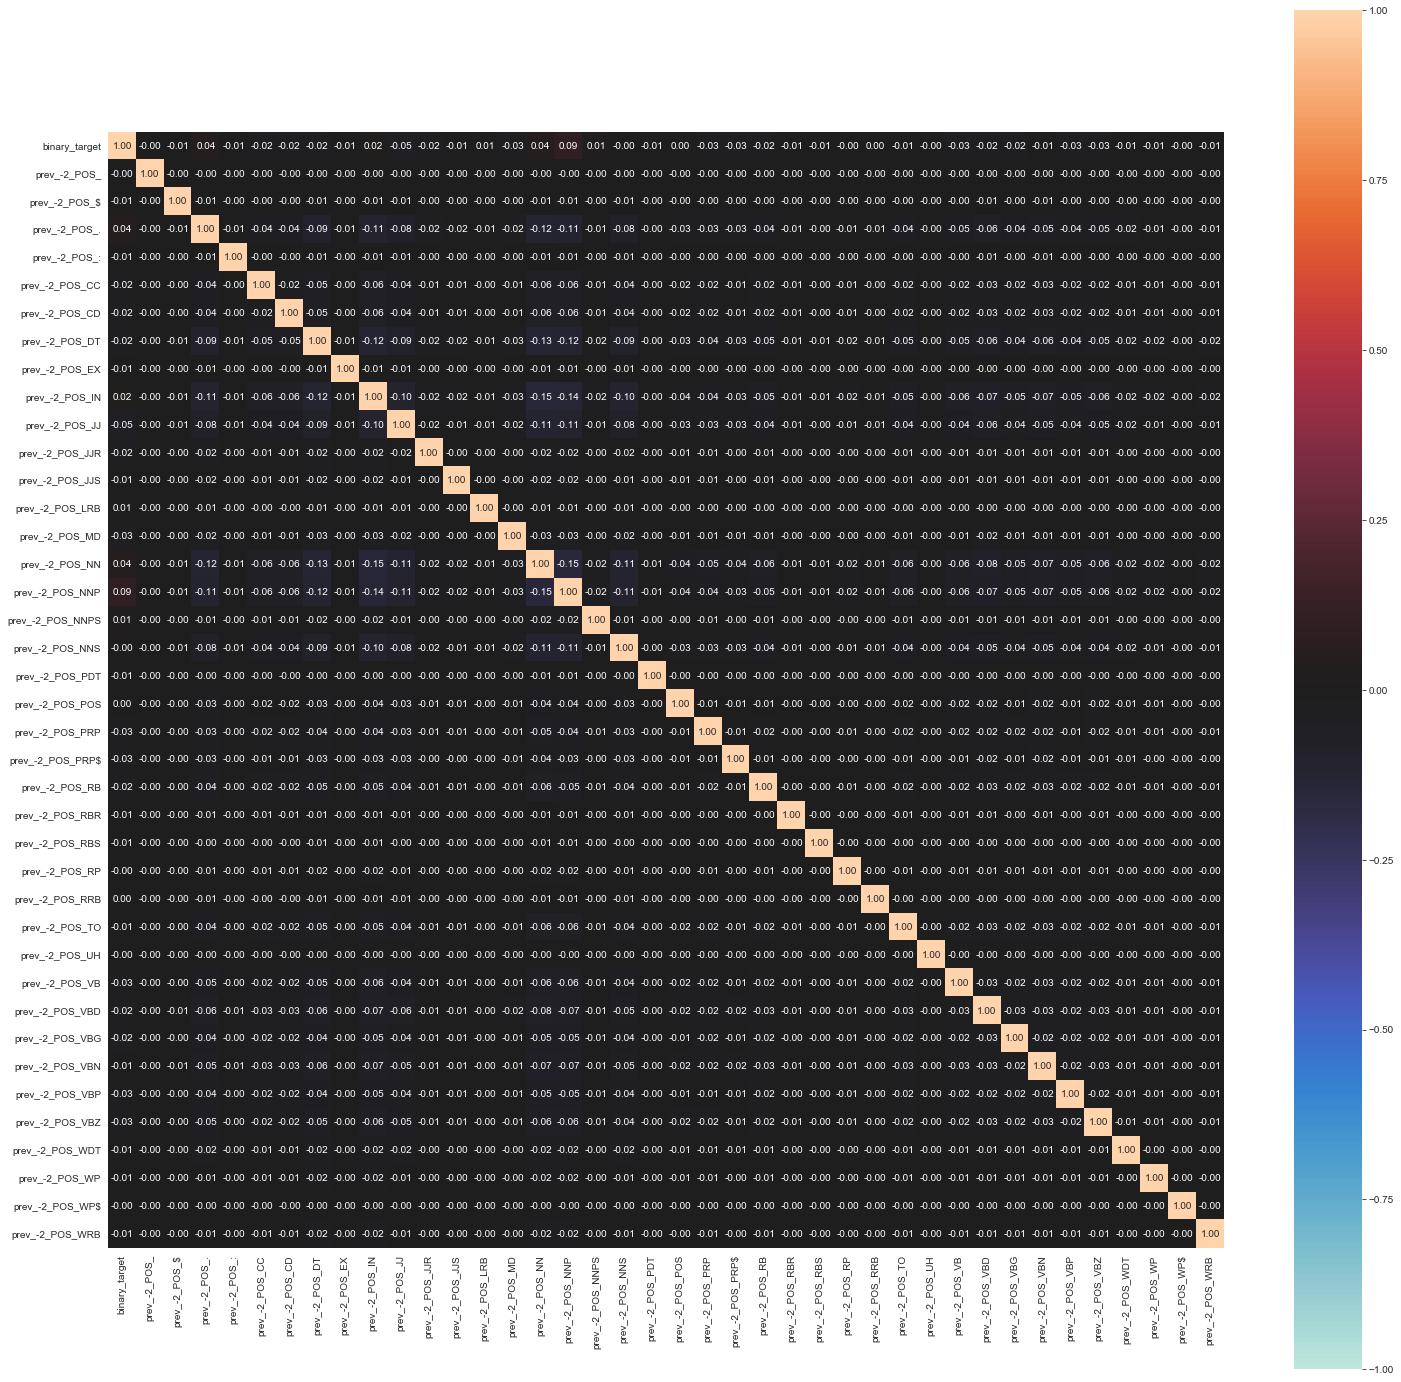

In [162]:
associations(dummies_df_2, theil_u=True, figsize=(25,25));

There are no significant coefficients present in the prev_-2_POS data, so we'll discard all those variables. 

<a id=conc ><a/> 

## 6. Conclusions and feature selection for modelling
    
[LINK to table of contents](#contents)

A feature-based model depends on the quality of the features selected. From my analysis, the best features to include so far are:

* prev_-1_POS_NNP
* prev_-1_POS_NN
* is_title
* is_prev_POS_same_as_current
* length
* is_prev_NE
* POS_NNP
* POS_NN
* POS_IN
* POS_DT
* POS_.
* is_digit (kept because it'll likely be able to help us identify dates and times)
* is_upper (kept for acronym/abbreviation detection)

Let's save that dataframe as our features file. 

In [167]:
feature_df.columns

Index(['Sentence #', 'Word', 'POS', 'Tag', 'binary_target', 'is_title',
       'length', 'is_upper', 'is_digit', 'is_prev_NE', 'prev_-1_POS',
       'prev_-2_POS', 'is_first_in_sentence', 'is_prev_pos_same_as_current'],
      dtype='object')

In [169]:
final_features_df = feature_df.drop(columns=['Sentence #', 'Word', 'binary_target'])
final_features_df = pd.get_dummies(final_features_df, columns=['prev_-1_POS',
       'prev_-2_POS', 'POS'])
final_features_df = final_features_df[['Tag', 'is_title',
       'length', 'is_upper', 'is_digit', 'is_prev_NE', 'prev_-1_POS_NNP', 'prev_-1_POS_NN', 
                                    'is_prev_pos_same_as_current', 'POS_NNP', 'POS_NN', 'POS_IN', 'POS_DT', 'POS_.']]
final_features_df.head()

,Tag,is_title,length,is_upper,is_digit,is_prev_NE,prev_-1_POS_NNP,prev_-1_POS_NN,is_prev_pos_same_as_current,POS_NNP,POS_NN,POS_IN,POS_DT,POS_.
0,O,1,9,0,0,0,0,0,0,0,0,0,0,0
1,O,0,2,0,0,0,0,0,0,0,0,1,0,0
2,O,0,13,0,0,0,0,0,0,0,0,0,0,0
3,O,0,4,0,0,0,0,0,0,0,0,0,0,0
4,O,0,7,0,0,0,0,0,0,0,0,0,0,0


In [170]:
final_features_df.shape

(66161, 14)

In [171]:
final_features_df.to_pickle('feature_based_data/final_feature_data.pkl')